# Rating Prediction

Through this notebook, several models are trained and tested in order to find the most accurate (produces less errors) when predicting movie ratings. As stated, we developed 6 different models:

      - OLS (Linear Regression model);
      - Ridge model (alpha = 0.5);
      - Lasso Model (alpha = 0.5);
      - Bayesian Ridge;
      - Neural Network;
      - Keras model.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import metrics
from keras.layers import Dense
from keras.models import Sequential

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error , r2_score ,mean_squared_error

from IPython.display import display_html

In [4]:
movies_info = pd.read_csv('/content/drive/MyDrive/Dataset CSV movies_info.csv', index_col = 'tconst')
movie_actors = pd.read_csv('/content/drive/MyDrive/Dataset CSVmovies_actors.csv')

In [5]:
movies_info.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt1711493,movie,Petty Cash,Petty Cash,0,2010,\N,87,6.0,23,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt1772860,movie,Late December,Fin Décembre,0,2010,\N,104,7.9,29,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
tt1772864,movie,The Floating Lives,Cánh dong bat tan,0,2010,\N,105,7.0,320,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
tt1772924,movie,"Jeans, une planète en bleu","Jeans, une planète en bleu",0,2010,\N,\N,7.8,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt1468387,movie,What If...,What If...,0,2010,\N,111,6.4,2625,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
movie_actors.head()

,tconst,ordering,nconst,category,job,characters,startYear,averageRating
0,tt0011216,1,nm0290157,actress,\N,"[""Soledad""]",2019,6.9
1,tt0011216,2,nm0300388,actor,\N,\N,2019,6.9
2,tt0011216,3,nm0869559,actor,\N,"[""Miguélan""]",2019,6.9
3,tt0011216,4,nm0595321,actor,\N,"[""Réal""]",2019,6.9
4,tt0016906,10,nm0530110,actress,\N,\N,2014,5.6


In [7]:
movies_info = movies_info[movies_info['startYear'] >= 2020]
movies_info = movies_info[movies_info['runtimeMinutes'] != r'\N']

In [8]:
movie_actors = movie_actors.loc[movie_actors['tconst'].isin(movies_info.index)]
actors = pd.DataFrame(0, index = movies_info.index, columns = movie_actors['nconst'].unique())
movies_info = pd.merge(movies_info,actors, on = 'tconst')

In [9]:
movie_actors.head()

,tconst,ordering,nconst,category,job,characters,startYear,averageRating
12,tt0062336,1,nm0815612,actor,\N,"[""Viudo""]",2020,6.3
13,tt0062336,2,nm1860495,actress,\N,"[""Fantasma""]",2020,6.3
14,tt0062336,3,nm0016013,actor,\N,"[""Silva""]",2020,6.3
15,tt0062336,4,nm0739834,actress,\N,"[""Lola""]",2020,6.3
20,tt0093119,1,nm0000123,actor,\N,"[""Ron""]",2020,3.4


In [10]:
movies_info.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,nm0815612,nm1860495,nm0016013,nm0739834,...,nm2586196,nm10097892,nm0685222,nm0378245,nm10067359,nm9450235,nm7434342,nm9007992,nm2988542,nm5608098,nm4079236,nm2850234,nm3055239,nm0936300,nm0424819,nm2933542,nm0717709,nm0677944,nm3646923,nm0200702,nm1446274,nm0431221,nm8821891,nm7288448,nm10900172,nm9955536,nm0277932,nm0824373,nm3362584,nm2558112,nm6864841,nm2778042,nm11685100,nm0302466,nm2952127,nm2018573,nm3080119,nm9428255,nm3766704,nm10678594
tconst,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt8430018,movie,Chess Match,Chess Match,0,2020,\N,100,5.8,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt12354874,movie,Ginger's Tale,Ogoniok-ognivo,0,2020,\N,88,5.7,188,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt2400305,movie,Captured,Captured,0,2020,\N,80,4.7,86,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt12306926,movie,DAU. Brave People,DAU. Smelye ludi,0,2020,\N,153,5.7,91,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt12356438,movie,Sanders Complaint: America's Greatest Socialis...,Sanders Complaint: America's Greatest Socialis...,0,2020,\N,91,8.5,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
for movie, info in movies_info.iterrows():
    for actor in movie_actors[movie_actors['tconst'] == movie]['nconst']:
        movies_info[actor][movie] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
movies_info.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,nm0815612,nm1860495,nm0016013,nm0739834,...,nm2586196,nm10097892,nm0685222,nm0378245,nm10067359,nm9450235,nm7434342,nm9007992,nm2988542,nm5608098,nm4079236,nm2850234,nm3055239,nm0936300,nm0424819,nm2933542,nm0717709,nm0677944,nm3646923,nm0200702,nm1446274,nm0431221,nm8821891,nm7288448,nm10900172,nm9955536,nm0277932,nm0824373,nm3362584,nm2558112,nm6864841,nm2778042,nm11685100,nm0302466,nm2952127,nm2018573,nm3080119,nm9428255,nm3766704,nm10678594
tconst,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt8430018,movie,Chess Match,Chess Match,0,2020,\N,100,5.8,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt12354874,movie,Ginger's Tale,Ogoniok-ognivo,0,2020,\N,88,5.7,188,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt2400305,movie,Captured,Captured,0,2020,\N,80,4.7,86,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt12306926,movie,DAU. Brave People,DAU. Smelye ludi,0,2020,\N,153,5.7,91,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt12356438,movie,Sanders Complaint: America's Greatest Socialis...,Sanders Complaint: America's Greatest Socialis...,0,2020,\N,91,8.5,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


To train and test any model, you must split the data into train and test sets. Before splitting, we standardized our regressors.

In [13]:
y = movies_info['averageRating']
x = movies_info.drop(['titleType','primaryTitle','originalTitle','endYear'], axis = 1)

In [14]:
scaler = StandardScaler()
x[['startYear','runtimeMinutes','numVotes']] = scaler.fit_transform(x[['startYear','runtimeMinutes','numVotes']])

In [15]:
#Split Train and Test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.80, random_state = 50)

# Model results function

After preparing the data, it is time to train our models. In order to do so, we created a function that receives as arguments:

- model: model to be trained and tested;
- x_train: training set (regressors);
- y_train: training set (dependent variable);
- x_test: test set (regressors);
- y_test: test set (dependent variable).

The function will then return a data frame displaying the R2, MAE, MSE for both the train and test data

In [16]:
#Function to get models results
def results(model,x_train,y_train,x_test,y_test):

    model.fit(x_train,y_train.values.ravel())
        
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
        
    r2 = r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)
    mae = mean_absolute_error(y_train,y_pred_train), mean_absolute_error(y_test,y_pred_test)
    mse = mean_squared_error(y_train,y_pred_train), mean_squared_error(y_test,y_pred_test)
    result = pd.DataFrame([[r2[0],r2[1]],
                           [mae[0],mae[1]],
                           [mse[0],mse[1]]],index = ['R2','MAE','MSE'],columns = ['Train Data','Test Data'])
    return result

# OLS Model

In [17]:
# object creation and model fit OLS
ols_model = linear_model.LinearRegression()
ols_results = results(ols_model,x_train,y_train,x_test,y_test)
ols_results

,Train Data,Test Data
R2,1.000000e+00,0.999975
MAE,3.788029e-15,0.000798
MSE,7.953460e-28,0.000072


# Ridge Model
# alpha = 0.5

In [18]:
# object creation and model fit Ridge with parameter alpha=0.5
rdg_model = linear_model.Ridge(alpha = 0.5)
rdg_results = results(rdg_model,x_train,y_train,x_test,y_test)
rdg_results

,Train Data,Test Data
R2,1.000000e+00,1.000000e+00
MAE,4.593692e-05,1.799205e-04
MSE,7.983787e-09,5.391174e-08


# Lasso Model
# alpha = 0.5

In [19]:
# object creation and model fit Lasso with parameter alpha=0.5
lss_model = linear_model.Lasso(alpha = 0.5)
lss_results = results(lss_model,x_train,y_train,x_test,y_test)
lss_results

,Train Data,Test Data
R2,0.965733,0.965733
MAE,0.243606,0.251536
MSE,0.092557,0.098561


# BayesianRidge Model

In [ ]:
# object creation and model fit BayesianRidge with parameter compute_score=True
brdg_model = linear_model.BayesianRidge(compute_score=True)
brdg_results = results(brdg_model,x_train,y_train,x_test,y_test)
brdg_results

# Neural Network

In [ ]:
# Object creation Neural Network
nn_model = MLPRegressor(random_state=1, activation='relu', max_iter=300, solver='adam')
nn_results = results(nn_model,x_train,y_train,x_test,y_test)
nn_results

# Keras model

In [ ]:
Y_train,Y_test = y_train.values, y_test.values

In [ ]:
k_model = Sequential([
    Dense(10, input_dim=x_train.shape[1], activation='relu'),
    Dense(30, activation='relu'),
    Dense(40, activation='relu'),
    Dense(1)
])
k_model.compile(optimizer ='adam', loss = 'mean_squared_error', 
            metrics =[metrics.mae])

In [ ]:
k_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                189870    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 191,481
Trainable params: 191,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = k_model.fit(x_train, Y_train, validation_data=(x_test,Y_test), epochs = 40, batch_size=32)

Epoch 1/40
157/157 [==============================] - 15s 10ms/step - loss: 27.6647 - mean_absolute_error: 4.6202 - val_loss: 0.3073 - val_mean_absolute_error: 0.4368
Epoch 2/40
157/157 [==============================] - 1s 7ms/step - loss: 0.2213 - mean_absolute_error: 0.3668 - val_loss: 0.1663 - val_mean_absolute_error: 0.3197
Epoch 3/40
157/157 [==============================] - 1s 6ms/step - loss: 0.0629 - mean_absolute_error: 0.1858 - val_loss: 0.1216 - val_mean_absolute_error: 0.2737
Epoch 4/40
157/157 [==============================] - 1s 6ms/step - loss: 0.0280 - mean_absolute_error: 0.1117 - val_loss: 0.1020 - val_mean_absolute_error: 0.2504
Epoch 5/40
157/157 [==============================] - 1s 6ms/step - loss: 0.0202 - mean_absolute_error: 0.0889 - val_loss: 0.0923 - val_mean_absolute_error: 0.2382
Epoch 6/40
157/157 [==============================] - 1s 6ms/step - loss: 0.0190 - mean_absolute_error: 0.0840 - val_loss: 0.0801 - val_mean_absolute_error: 0.2215
Epoch 7/40
15

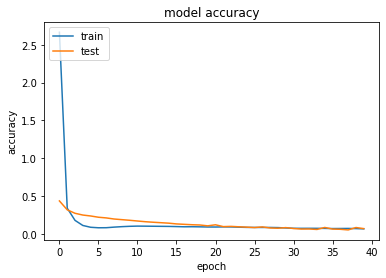

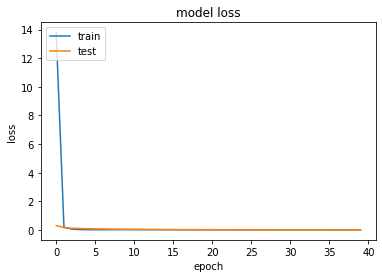

In [ ]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred_train = k_model.predict(x_train)
y_pred_test = k_model.predict(x_test)
k_r2 = r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)
k_mae = mean_absolute_error(y_train,y_pred_train), mean_absolute_error(y_test,y_pred_test)
k_mse = mean_squared_error(y_train,y_pred_train), mean_squared_error(y_test,y_pred_test)
k_results = pd.DataFrame([[k_r2[0],k_r2[1]],
                          [k_mae[0],k_mae[1]],
                          [k_mse[0],k_mse[1]]],index = ['R2','MAE','MSE'],columns = ['Train Data','Test Data'])
k_results

,Train Data,Test Data
R2,0.997247,0.997183
MAE,0.067575,0.071317
MSE,0.007647,0.007609


In [ ]:
modelos = (ols_results,rdg_results,lss_results,nn_results,k_results)
train = np.zeros((len(modelos), 3))
test = np.zeros((len(modelos), 3))

for i in range(len(modelos)):
    train[i][0] = modelos[i]['Train Data']['R2']
    test[i][0] = modelos[i]['Test Data']['R2']     
    train[i][1] = modelos[i]['Train Data']['MAE']
    test[i][1] = modelos[i]['Test Data']['MAE']
    train[i][2] = modelos[i]['Train Data']['MSE']
    test[i][2] = modelos[i]['Test Data']['MSE']

models_names = ['OLS','Ridge','Lasso','Neural Network', 'Keras Model']
train_resume = pd.DataFrame(data = train, columns = ['R2','MAE','MSE'], index= models_names)
test_resume = pd.DataFrame(data = test, columns = ['R2','MAE','MSE'], index= models_names)


train_styler = train_resume.style.set_table_attributes("style='display:inline'").set_caption('Train Data')
test_styler = test_resume.style.set_table_attributes("style='display:inline'").set_caption('Test Data')
space = "\xa0" * 15
display_html(train_styler._repr_html_()+ space  + test_styler._repr_html_(), raw=True)

,R2,MAE,MSE
OLS,1.000000,0.000000,0.000000
Ridge,1.000000,0.000058,0.000000
Lasso,0.967598,0.239817,0.090002
Neural Network,0.999180,0.022509,0.002277
Keras Model,0.997247,0.067575,0.007647
,R2,MAE,MSE
OLS,0.999675,0.005018,0.000879
Ridge,1.000000,0.000218,0.000000
Lasso,0.967568,0.237683,0.087596
Neural Network,0.994833,0.092314,0.013957


All models used produce extremely good results for the evaluation measures used. Note that we want a model with:

R2 as close to 1 as possible;
MAE and MSE as close to 0 as possible.
To decide which model to use, we first focus our attention on Test data (Train data was used to train the model).

The model that produces the best results is the Ridge Model.